# Module 2 Project - KC Housing Price Regression

# Scope and Business Understanding
I will be building a multivariate regression on the KC Housing Dataset with the goal of predicting house sale price as accurately as possible. This exercise will be completed in the context of a private equity / real estate investment firm looking for diligence and valuation support. Ideally, this regression will help identify statistically significant variables to target during due diligence processes to ensure time is spent researching aspects of a house that are meaningful to price. Additionally, if the data supports it, firms will be able to leverage this data to determine which potential future projects might be correlated with higher sales prices to guide renovation work. Ultimately, using the tool for buyers and sellers, this tool can be used to minimize risk and help improve return realization. 

I will aim to answer the following three primary questions:
1. What does the current KC housing market look like and what do the majority of houses have in common
2. Are there specific times (years, months, days) that might be related with a higher sale price?
3. Are provided rankings (grade, condition, etc.) trustworthy and are they actually relevant to predicting sale price?

# Data Understanding

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as stats
%matplotlib inline

In [2]:
# set style of graphs and visualizations
plt.style.use('ggplot')

In [3]:
# import raw dataset
raw_df = pd.read_csv('kc_house_data.csv')
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

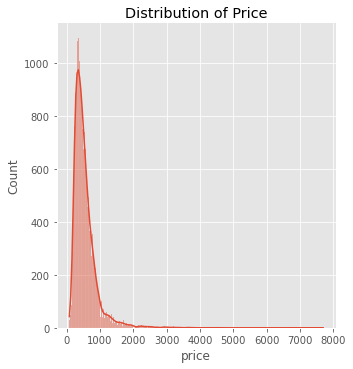

In [4]:
# visualize distribution of target
sns.displot(data=raw_df['price']/1000, kde=True)
plt.title('Distribution of Price')
plt.show()

Variable will likely benefit from some sort of transformation - - will evaluate results of baseline prior to any transforming of variables.

In [5]:
raw_df['price'].describe()

count    2.159700e+04
mean     5.402966e+05
std      3.673681e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

Target variable has some significant right skew, with the majority of values falling under 2M.

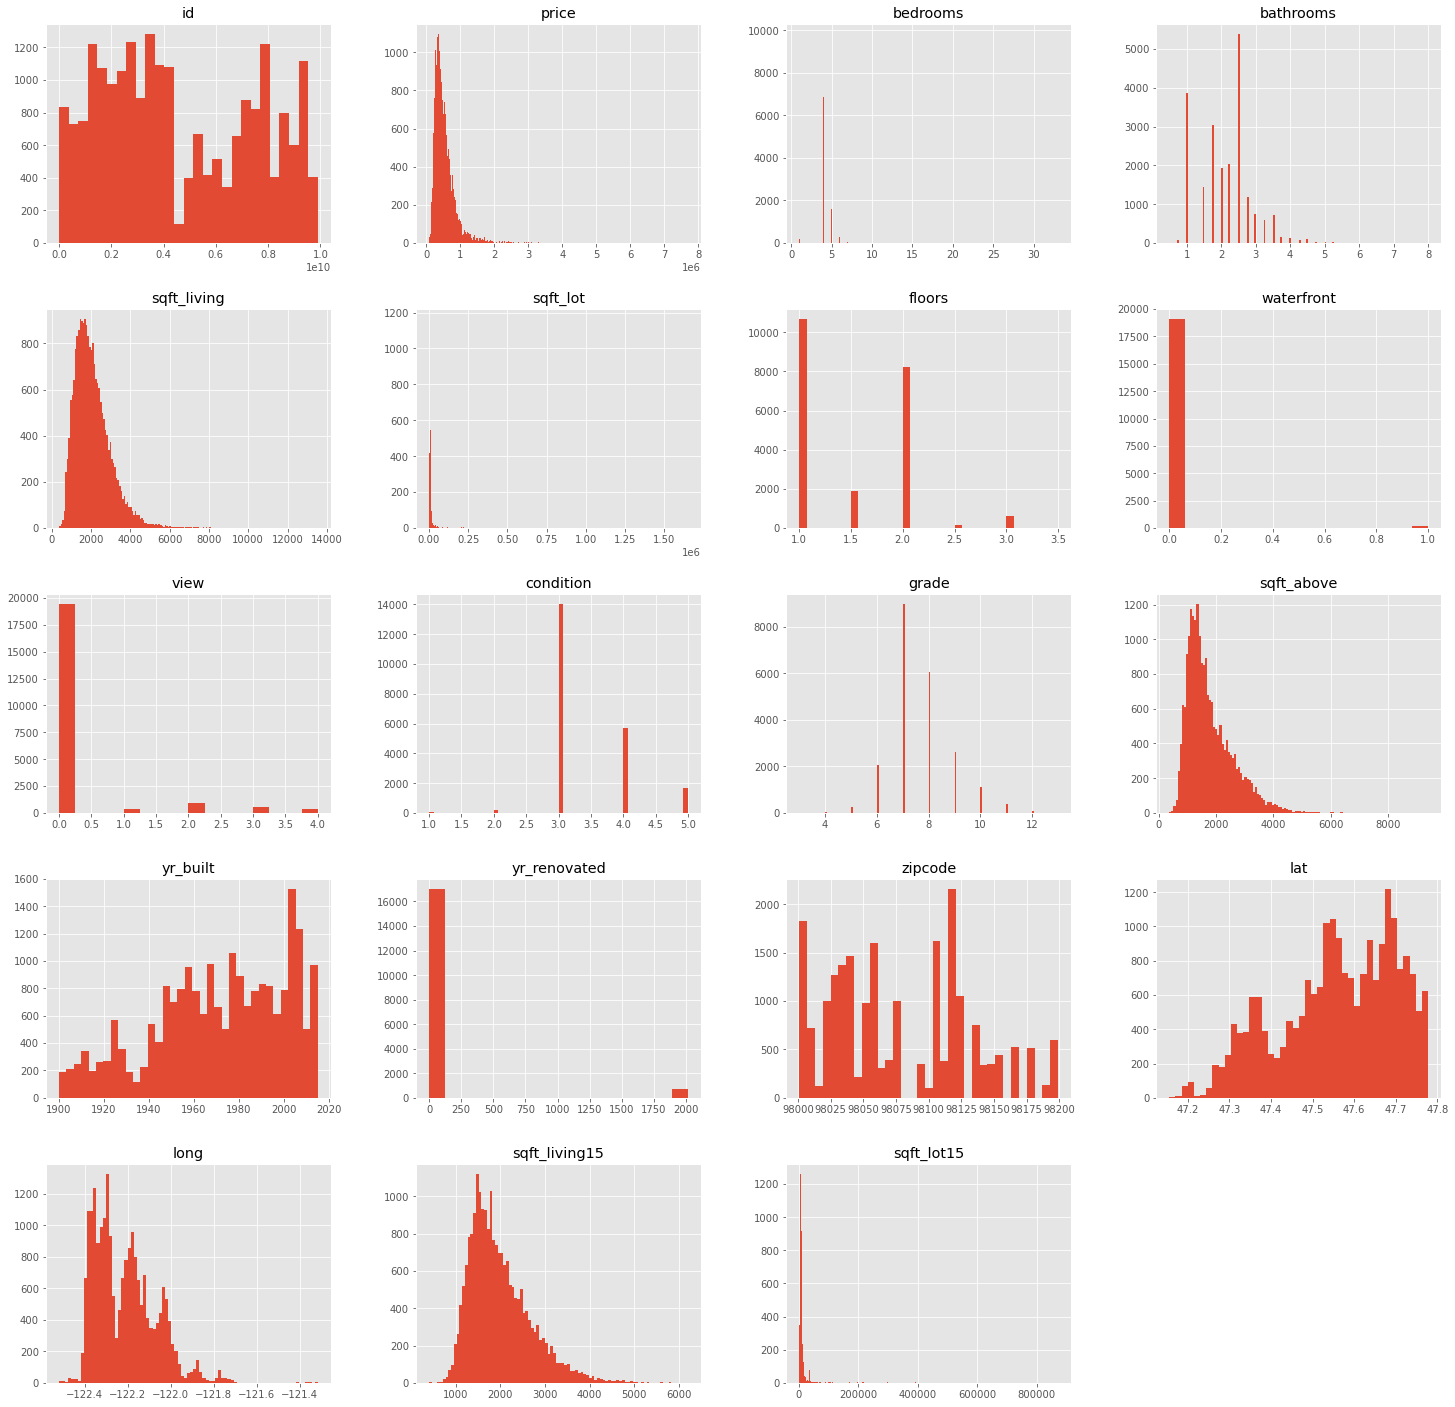

In [6]:
# explore distribution of data - plot histograms of each variable
raw_df.hist(figsize=(25, 25), bins='auto')
plt.show()

In [7]:
# produce summary statistics
raw_df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21534.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,0.233863,3.409825,7.657915,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.765686,0.650546,1.173200,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


 - bathrooms: appears to be categorical with the majority of entries falling between 0.5 and 3 bathrooms. there are a number of outliers to the right, with one entry having 8 bedrooms.  Room to clean these outliers up after the baseline model is generated.  Summary stats presented above, shows a median of 2.25 bathrooms, and a standard deviation of just over 0.75 bathrooms
 - bedrooms: appears to be categorical with the majority of entries having 1 to 4 bedrooms.  Significant oulier with one entry having 33 bedrooms.  Median number of bedrooms is 3, with a standard deviation of just under 1 bedroom
 - condition: appears categorical, max of 5, median of 3 - - looks like the majority are condition ratings of 3 and 4.  standard deviation of 0.65 (just over half one condition rating)
 - day_sold: appears to be categorical.  Looks like there is no deviation other than near the beginning of the month (day 1) and the middle of the month (day ~20) showing more houses sold near these days than on others
 - floors: categorical with a significant falloff after 2 floors
 - grade: appears somewhat normally distributed although it is categorical.  Some grades above 10, with the most between 6 and 9.  Median grade is 7 with a std of 1.17
 - month_sold: categorical, but interesting to see that there are more houses sold during the summer months than winter months, which makes sense
 - price, sqft_above, sqft_living, sqft_living15 appear log normally distributed, with right skew and likely some positive outliers
 - sqft_lot and sqft_lot15 have have significant right skew and outliers
 - view: very few houses have been viewed (> 0 value)
 - waterfront: very few houses have waterfront
 - year_sold: only two years of sale data is included here (2014 and 2015), with more entries coming from 2014 than 2015
 - yr_built: the majority of houses represented were built after 1950, with the earliest house included being built in 1900
 - yr_renovated: only a handful have received renovations

In [8]:
# print data types of each column
for col in raw_df.columns:
    print(f'{col}-{raw_df[col].dtype}')

id-int64
date-object
price-float64
bedrooms-int64
bathrooms-float64
sqft_living-int64
sqft_lot-int64
floors-float64
waterfront-float64
view-float64
condition-int64
grade-int64
sqft_above-int64
sqft_basement-object
yr_built-int64
yr_renovated-float64
zipcode-int64
lat-float64
long-float64
sqft_living15-int64
sqft_lot15-int64


`sqft_basement` and `date` are the only two columns that are non-numerical, will need to be handled during data preparation. 

# Data Preparation
This section will be used to prepare our dataset for modeling. Steps include handling missing values, data typing columns, and encoding categorical features. 

In [9]:
def plot_viz(data, target, predictors, nrows=1, ncols=1, figsize=(10, 4)):
    """
    Function to plot y vs. a chosen set of x variables: includes regression line
    Parameters:
        data: name of dataframe variables are coming from
        target: string of target variable
        predictors: dataframe of predictors
        nrows: number of rows of subplots
        ncols: number of cols of subplots
        figsize: size of the figure
    """
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for ax, feature in zip(axes.flatten(), predictors):
        sns.regplot(x=feature, y=target, data=data, ax=ax, scatter_kws={'alpha':0.2});
        ax.set_title(f'{feature} vs. {target}')
    plt.tight_layout()

In [10]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """
    Function to perform a forward-backward feature selection
    based on p-value from statsmodels.api.OLS
    Parameters:
        X: pandas.Dataframe with candidate features
        y: list-like with the target
        initial_list: list of features to start with (column names of X)
        threshold_in: include a feature if its p-val < threshold_in
        threshold_out: exclude a feature if its p-val > threshold_out
        verbose: whether to print the sequence of inclusions and exclusions
    Returns: list of selected features
    Note: always set threshold_in < threshold_out to avoid infinite looping
    """
    included = list(initial_list)
    while True:
        changed=False
        
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded, dtype='float64')
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [11]:
def multi_collinearity(data_pred, percent_correlated=0.75):
    """
    Function to identify multi-collinearity based on a threshold value.
    Parameters:
        data_pred: predictor variables
        percent_correlated: threshold percentage to determine the level of correlation to identify
    Returns: Dataframe of correlated pairs, with duplicates removed
    """
    
    df = data_pred.corr().abs().stack().reset_index().sort_values(0, ascending=False)
    
    # zip the variable name columns (named level_0 and level_1 by default) in a new column named "pairs"
    df['pairs'] = list(zip(df.level_0, df.level_1))
    
    # set index to pairs
    df.set_index(['pairs'], inplace=True)
    
    # drop level columns
    df.drop(columns=['level_1', 'level_0'], inplace=True)
    
    # rename correlation column as cc rather than 0
    df.columns = ['cc']
    
    # drop duplicates
    df.drop_duplicates(inplace=True)
    
    return df[(df.cc > percent_correlated) & (df.cc < 1)]

In [12]:
# start by dropping id column as this will not help with predicting price
clean_df = raw_df.drop('id', axis=1)

In [13]:
# check for missing values
clean_df.isna().sum()

date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

We can see we are missing values in three columns - waterfront, yr_renovated, and view, with far more missing out of waterfront and yr_renovated.

In [14]:
# calc percentage of data missing
waterfront_missing = round(clean_df['waterfront'].isna().sum() / len(clean_df), 4)
yr_renovated_missing = round(clean_df['yr_renovated'].isna().sum() / len(clean_df), 4)
view_missing = round(clean_df['view'].isna().sum() / len(clean_df), 4)

# print percentages
print(f'Missing waterfront values comprise {waterfront_missing * 100}% of total data')
print(f'Missing yr_renovated values comprise {yr_renovated_missing * 100}% of total data')
print(f'Missing view values comprise {view_missing * 100}% of total data')

Missing waterfront values comprise 11.0% of total data
Missing yr_renovated values comprise 17.79% of total data
Missing view values comprise 0.29% of total data


Given the large amount of data missing values represent, we will likely not want to remove these from the dataset as it will result in a major loss of data. 

In [15]:
# explore other values in these columns
print('waterfront')
display(clean_df['waterfront'].unique())
print('yr_renovated')
display(clean_df['yr_renovated'].unique())
print('view')
display(clean_df['view'].unique())

waterfront


array([nan,  0.,  1.])

yr_renovated


array([   0., 1991.,   nan, 2002., 2010., 1992., 2013., 1994., 1978.,
       2005., 2003., 1984., 1954., 2014., 2011., 1983., 1945., 1990.,
       1988., 1977., 1981., 1995., 2000., 1999., 1998., 1970., 1989.,
       2004., 1986., 2007., 1987., 2006., 1985., 2001., 1980., 1971.,
       1979., 1997., 1950., 1969., 1948., 2009., 2015., 1974., 2008.,
       1968., 2012., 1963., 1951., 1962., 1953., 1993., 1996., 1955.,
       1982., 1956., 1940., 1976., 1946., 1975., 1964., 1973., 1957.,
       1959., 1960., 1967., 1965., 1934., 1972., 1944., 1958.])

view


array([ 0., nan,  3.,  4.,  2.,  1.])

Looking at the value distribution for the three columns with missing values, can see the following:
* waterfront: only two other values, either 0 or 1. Missing values are likely instances where waterfront=0
* yr_renovated: 0 values refer to non-renovated houses.  Missing values are likely the same
* view: 5 other classes of view

Given these observations, the missing values will be handled in the following manner:
* waterfront: NaNs assigned value of 0
* yr_renovated: NaNs assigned value of 0
* view: NaNs assigned value of column median

In [16]:
# handle missing values
clean_df['waterfront'] = clean_df['waterfront'].fillna(value=0.)
clean_df['yr_renovated'] = clean_df['yr_renovated'].fillna(value=0.)
clean_df['view'] = clean_df['view'].fillna(value=clean_df['view'].median())

In [17]:
# check for duplicates
clean_df.duplicated().sum()

0

We have handled missing values and there are no duplicated entries.  Will move on to handling dtypes of columns.  Will ultimately want all columns to be in numerical format. 

In [18]:
# further explore value counts in sqft_basement
clean_df['sqft_basement'].value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
295.0         1
283.0         1
1245.0        1
207.0         1
2730.0        1
Name: sqft_basement, Length: 304, dtype: int64

We can see there are some entries with a `sqft_basement` value of `?`. Given there are only 454 of these, drop them from the dataset. 

In [19]:
# drop ? values from sqft_basement
clean_df = clean_df.loc[clean_df['sqft_basement'] != '?']

# convert back to number format
clean_df['sqft_basement'] = clean_df['sqft_basement'].astype('float')

In [20]:
# convert date column to datetime and then split into year, month, day
clean_df['date'] = pd.to_datetime(clean_df['date'], infer_datetime_format=True)
clean_df['year'] = clean_df['date'].map(lambda x: x.year)
clean_df['month'] = clean_df['date'].map(lambda x: x.month)
clean_df['day'] = clean_df['date'].map(lambda x: x.day)

# drop initial date column
clean_df = clean_df.drop('date', axis=1)

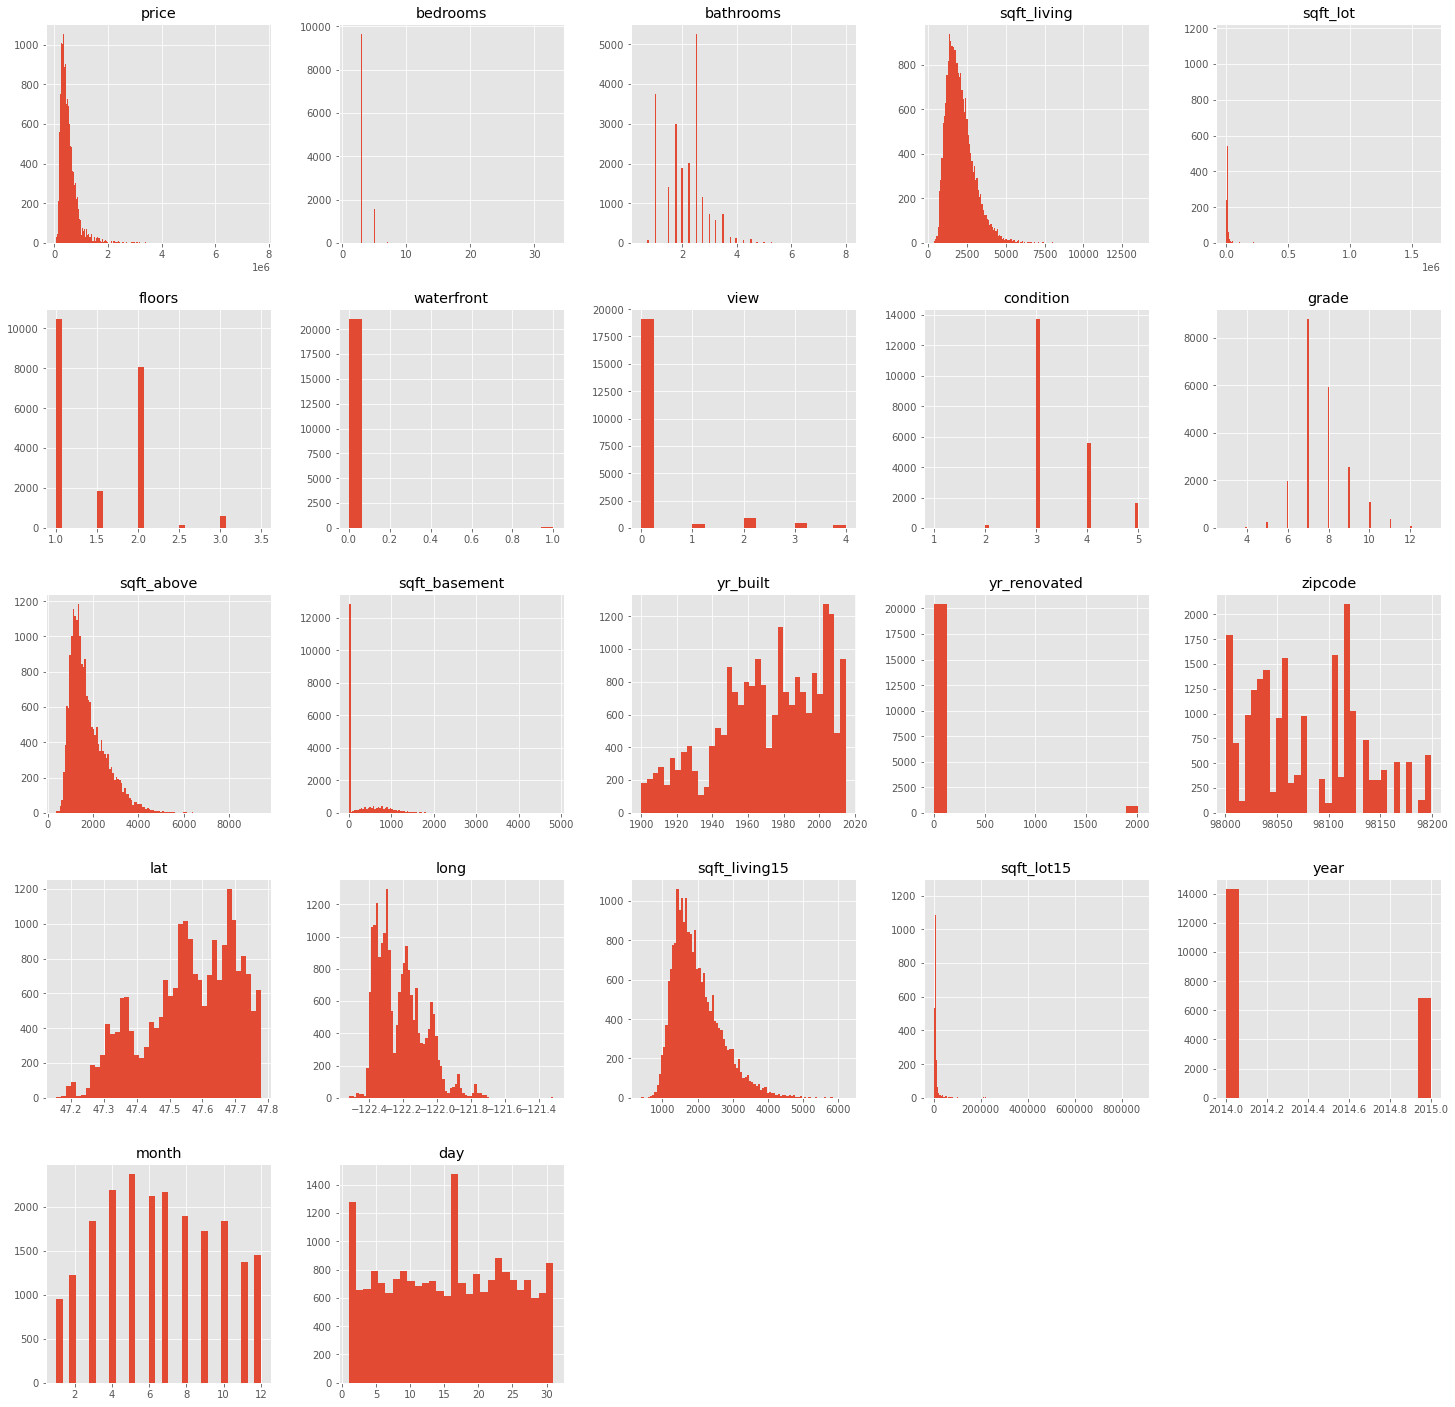

In [21]:
# reprint histograms of each column
clean_df.hist(figsize=(25, 25), bins='auto')
plt.show()

In [22]:
# separate categorical features from continuous features
cat_cols = []
for col in clean_df.columns:
    if len(clean_df[col].unique()) < 35: # if num unique values is less than 35
        cat_cols.append(col)
cat_feats = clean_df[cat_cols]
print(cat_feats.columns)
print(f'\nNumber of categorical features: {len(cat_feats.columns)}')

Index(['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'year', 'month', 'day'],
      dtype='object')

Number of categorical features: 10


Doing a quick sanity check of the columns returned, these all make sense as categorical. Separate out the remaining features into a continuous features dataframe.

In [23]:
# separate out continous cols
cont_feats = clean_df.drop(cat_cols, axis=1)
cont_feats = cont_feats.drop('price', axis=1)
print(cont_feats.columns)
print(f'\nNumber of continuous features: {len(cont_feats.columns)}')

Index(['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15'],
      dtype='object')

Number of continuous features: 11


In [24]:
# separate target (dependent variable)
target = clean_df[['price']]

Now that the dataset is separated between continous features, categorical features, and the target variable, move forward with visualizing relationships of features vs. target. 

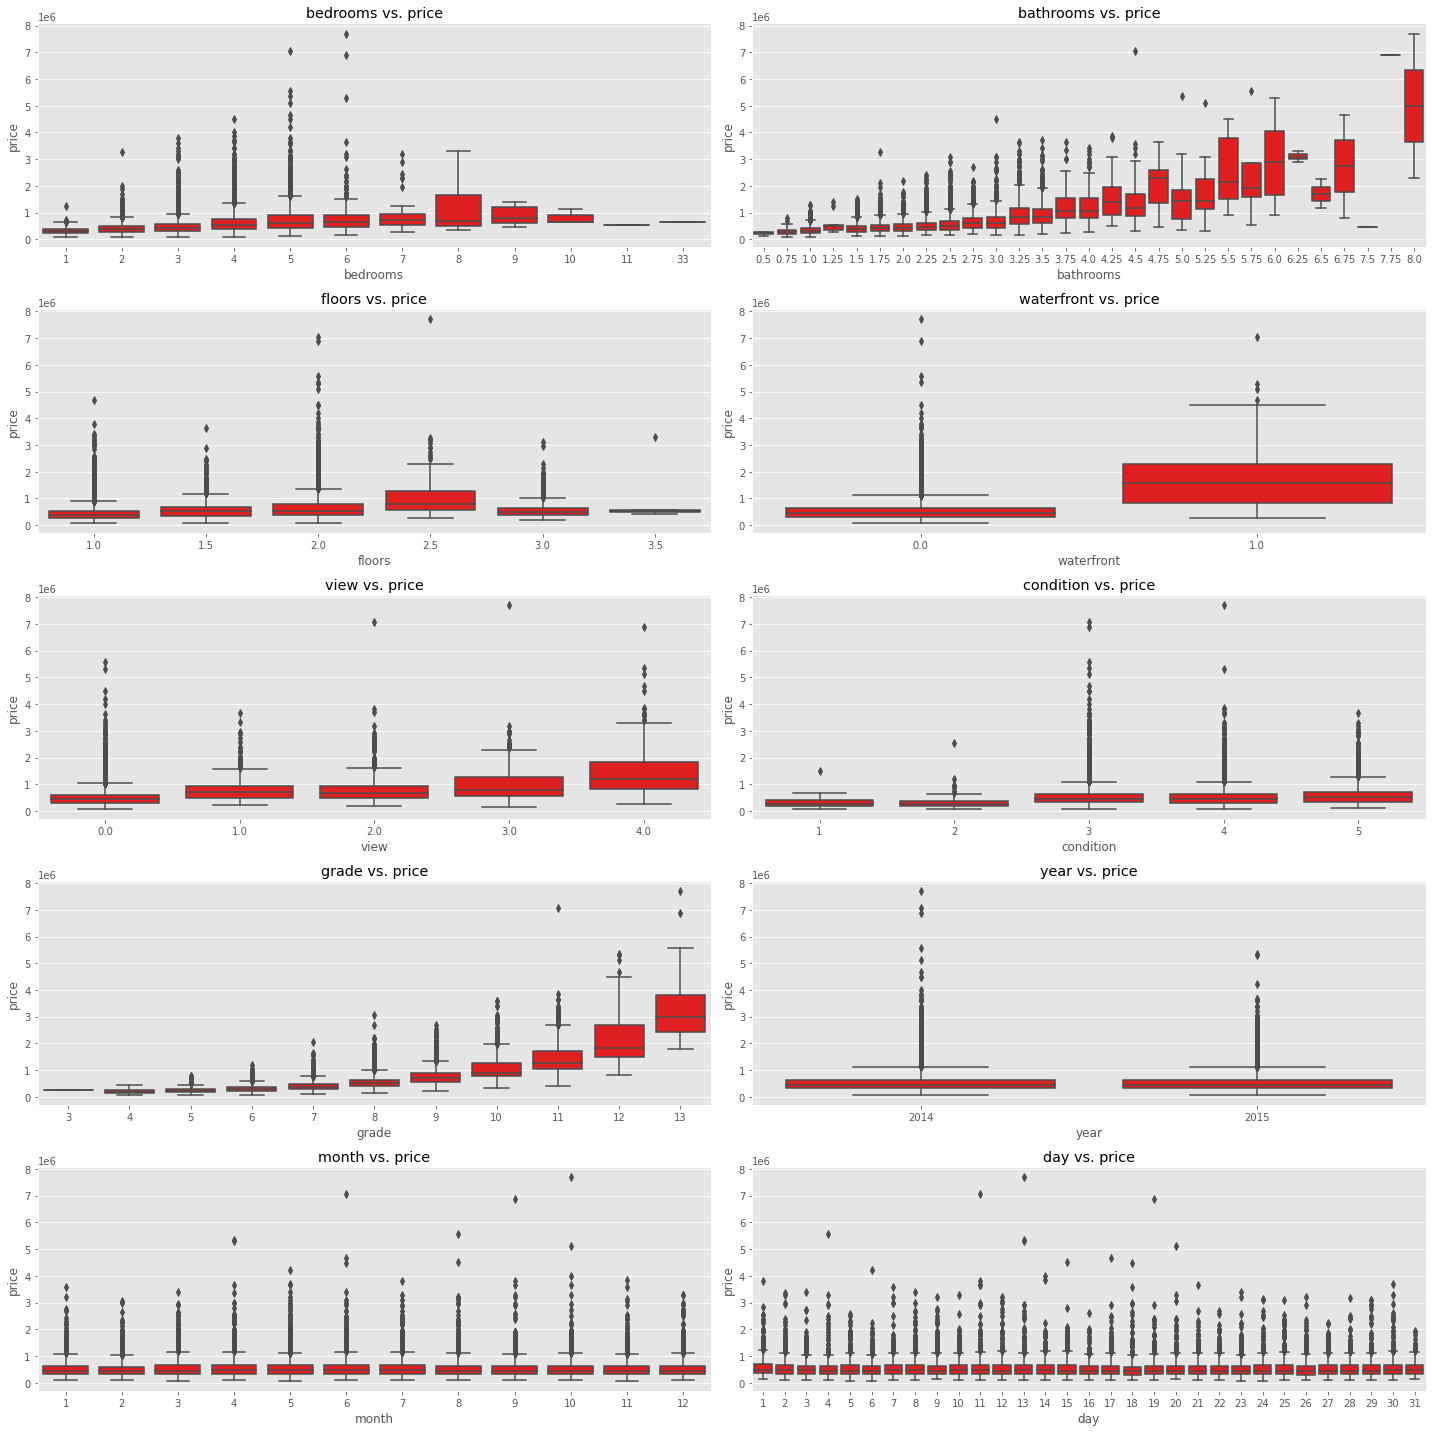

In [25]:
# plot boxplots of categorical features vs. price
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 20))
for ax, feat in zip(axes.flatten(), cat_feats):
    sns.boxplot(x=feat, y='price', data=clean_df, ax=ax, color='red')
    ax.set_title(f'{feat} vs. price')
plt.tight_layout()

Looking at the relationship between categorical features and price, we see the following:
- `bedrooms`: seems to be slight positive relationship with price, despite some weird data torwards the right tail, near bedroom values of 10 and greater
- `bathrooms`: seems to be a positive relationship with price until you get past 6 bathrooms
- `floors`: 2.5 floors seems to be correlated with the highest price homes
- `waterfront`: waterfront is associated with higher prices than no waterfront
- `view`: slight positive relationship with price
- `condition`: hard to discern relationship, houses with condition of 3 and higher seem correlated with higher house prices
- `grade`: positive ordinal relationship with price -- can potentially treat as a non-categorical feature
- `year`: No discernible difference
- `month`: No major difference, maybe some slight bump in median price for houses sold in spring months (months 4, 5, 6)
- `day`: no major difference in sale price between different sale days

The most influential features on price appear to be bedrooms, bathrooms, floors, waterfront, and grade

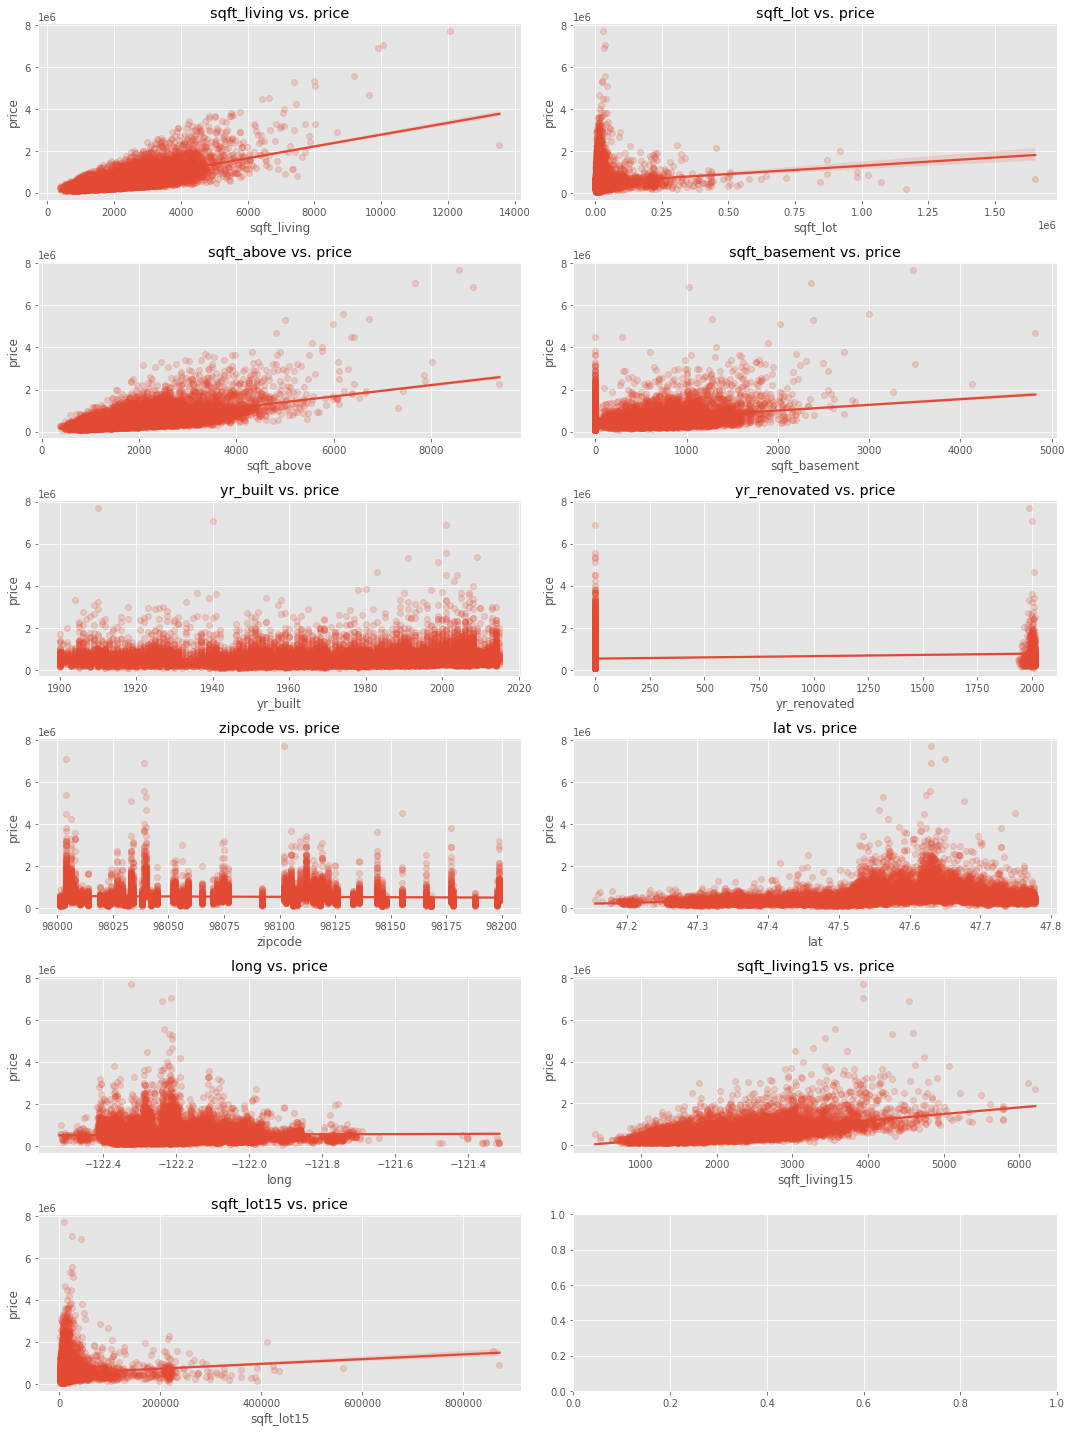

In [26]:
# plot scatterplots of cont. features vs. price
plot_viz(data=clean_df, target='price', predictors=cont_feats, 
         nrows=6, ncols=2, figsize=(15, 20))

Above we see:
- `sqft_living`: appears to be a fairly linear relationship with price, despite some increase in variance as you get torwards larger values of x
- `sqft_lot`: a lot of noise near lower values, relationship appears more linear as values increase
- `sqft_above`: similar relationship to `sqft_living` - fairly linear with price
- `sqft_basement`: a lot of `0` values, but fairly linear relationship with price 
- `yr_built`: No clear relationship with price
- `yr_renovated`: a lot of `0` values, hard to distinguish relationship with price
- `zipcode`: No clear pattern, but some zipcodes do appear to be related with higher median prices and some zipcodes appear to be related with lower median prices - - not linear, however
- `lat`: Non-linear relationship, with some spike in home prices when lat is between 47.5 and 47.8
- `long`: Non-linear relationship, some spike in home prices when long is between -122.4 and -122
- `sqft_living15`: Fairly positive linear relationship with price
- `sqft_lot15`: a lot of `0` values - - may not be linear or may be noise from lower values

From plotting variables vs. price, it is clear to see there are some features that likely have more predictive power than others. Additionally, it is evident some variables feature a lot of noise from 0 values. Finally, there a number of outliers present within the data and cleaning these up may yield improved results. 

In [27]:
# remove non-linear related features
non_linear = ['yr_built', 'zipcode']
preprocessed = clean_df.drop(non_linear, axis=1)

In [28]:
# separate features from target
y = preprocessed['price']
X = preprocessed.drop('price', axis=1)

In [29]:
# identify and remove multicollinearity if corr is greater than .75
correlated_feats = multi_collinearity(X, 0.75)
correlated_feats

,cc
pairs,
"(sqft_living, sqft_above)",0.876678
"(month, year)",0.782154
"(sqft_living, grade)",0.763101
"(sqft_living15, sqft_living)",0.756389
"(grade, sqft_above)",0.756382
"(bathrooms, sqft_living)",0.755278


`sqft_living` is likely a combination of `sqft_above` and `sqft_basement` and given its high correlation with a number of features, it will be removed from the dataset.

In [30]:
# drop sqft_living
preprocessed = preprocessed.drop(['sqft_living', 'year', 'day'], axis=1)

In [54]:
# scale floors and bathrooms as float decimals will create issues with OLS later
preprocessed['floors_10'] = preprocessed['floors'] * 10
preprocessed['bathrooms_100'] = preprocessed['bathrooms'] * 100

In [55]:
# drop initial columns
preprocessed = preprocessed.drop(['floors', 'bathrooms'], axis=1)
preprocessed.columns

Index(['price', 'bedrooms', 'sqft_lot', 'waterfront', 'view', 'condition',
       'grade', 'sqft_above', 'sqft_basement', 'yr_renovated', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'month', 'floors_10', 'bathrooms_100'],
      dtype='object')

In [56]:
# create dummy variables for categorical features
bedrooms_dummies = pd.get_dummies(preprocessed['bedrooms'], prefix='bedrooms', drop_first=True)
waterfront_dummies = pd.get_dummies(preprocessed['waterfront'], prefix='waterfront', drop_first=True)
view_dummies = pd.get_dummies(preprocessed['view'], prefix='view', drop_first=True)
condition_dummies = pd.get_dummies(preprocessed['condition'], prefix='condition', drop_first=True)
grade_dummies = pd.get_dummies(preprocessed['grade'], prefix='grade', drop_first=True)
month_dummies = pd.get_dummies(preprocessed['month'], prefix='month', drop_first=True)
floors_dummies = pd.get_dummies(preprocessed['floors_10'], prefix='floors', drop_first=True)
bathrooms_dummies = pd.get_dummies(preprocessed['bathrooms_100'], prefix='bathrooms', drop_first=True)

In [57]:
# concat encoded cat features
cat_ohe = pd.concat([bedrooms_dummies,
                     waterfront_dummies,
                     view_dummies,
                     condition_dummies,
                     grade_dummies,
                     month_dummies,
                     floors_dummies,
                     bathrooms_dummies], axis=1)

In [58]:
# set up final dataset for initial modeling
final_df = preprocessed.drop(['bedrooms',
                              'waterfront',
                              'view',
                              'condition',
                              'grade',
                              'month',
                              'floors_10',
                              'bathrooms_100'], axis=1)
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21143 entries, 0 to 21596
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21143 non-null  float64
 1   sqft_lot       21143 non-null  int64  
 2   sqft_above     21143 non-null  int64  
 3   sqft_basement  21143 non-null  float64
 4   yr_renovated   21143 non-null  float64
 5   lat            21143 non-null  float64
 6   long           21143 non-null  float64
 7   sqft_living15  21143 non-null  int64  
 8   sqft_lot15     21143 non-null  int64  
dtypes: float64(5), int64(4)
memory usage: 2.2 MB


In [59]:
# concat with dummy variables
final_df = pd.concat([final_df, cat_ohe], axis=1)

In [61]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21143 entries, 0 to 21596
Data columns (total 83 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   price            21143 non-null  float64
 1   sqft_lot         21143 non-null  int64  
 2   sqft_above       21143 non-null  int64  
 3   sqft_basement    21143 non-null  float64
 4   yr_renovated     21143 non-null  float64
 5   lat              21143 non-null  float64
 6   long             21143 non-null  float64
 7   sqft_living15    21143 non-null  int64  
 8   sqft_lot15       21143 non-null  int64  
 9   bedrooms_2       21143 non-null  uint8  
 10  bedrooms_3       21143 non-null  uint8  
 11  bedrooms_4       21143 non-null  uint8  
 12  bedrooms_5       21143 non-null  uint8  
 13  bedrooms_6       21143 non-null  uint8  
 14  bedrooms_7       21143 non-null  uint8  
 15  bedrooms_8       21143 non-null  uint8  
 16  bedrooms_9       21143 non-null  uint8  
 17  bedrooms_10 

# Baseline Modeling

In [62]:
# separate out features and target
y = final_df['price']
X = final_df.drop('price', axis=1)

# run stepwise selection to select features
result = stepwise_selection(X, y, verbose=True)

Add  grade_11                       with p-value 0.0
Add  grade_7                        with p-value 0.0
Add  sqft_above                     with p-value 0.0
Add  lat                            with p-value 0.0
Add  sqft_basement                  with p-value 0.0
Add  waterfront_1.0                 with p-value 0.0
Add  grade_12                       with p-value 8.14484e-212
Add  grade_13                       with p-value 2.40064e-218
Add  grade_10                       with p-value 1.07459e-214
Add  grade_9                        with p-value 3.57866e-134
Add  long                           with p-value 2.52098e-105
Add  condition_3                    with p-value 5.28729e-97
Add  yr_renovated                   with p-value 2.17307e-74
Add  view_4.0                       with p-value 6.41023e-63
Add  grade_8                        with p-value 1.28214e-55
Add  view_3.0                       with p-value 2.19019e-49
Add  bathrooms_775.0                with p-value 7.53171e-45
Add  v

In [63]:
# run regression with these features
X = final_df[result]
y = final_df['price']
predictors = sm.add_constant(X)
model = sm.OLS(y, predictors).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     1232.
Date:                Fri, 11 Mar 2022   Prob (F-statistic):               0.00
Time:                        11:50:51   Log-Likelihood:            -2.8701e+05
No. Observations:               21143   AIC:                         5.741e+05
Df Residuals:                   21095   BIC:                         5.745e+05
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -4.943e+07   1.38e+06    -35.835      0.000   -5.21e+07   -4.67e+07
grade_11         5.671e+05   1.38e+04     41.145      0.000     5.4e+05    5.94e+05
grade_7          3.741e+04   4823.449      7.756      0.000     2.8e+04    4.69e+04
sqft_above        127.7641      3.442     37.122      0.000     121.018     134.510
lat              6.106e+05   9869.658     61.865      0.000    5.91e+05     6.3e+05
sqft_basement     131.7709      3.790     34.766      0.000     124.342     139.200
waterfront_1.0   5.634e+05   1.96e+04     28.789      0.000    5.25e+05    6.02e+05
grade_12         9.604e+05   2.42e+04     39.622      0.000    9.13e+05    1.01e+06
grade_13         1.738e+06   6.14e+04     28.295      0.000    1.62e+06    1.86e+06
grade_10         3.651e+05   9585.048     38.094      0.000    3.46e+05    3.84e+05
grade_9          2.171e+05   7388.819     29.382      0.000    2.03e+05    2.32e+05
long            -1.669e+05   1.09e+04    -15.247      0.000   -1.88e+05   -1.45e+05
yr_renovated       65.7229      3.668     17.918      0.000      58.533      72.912
view_4.0         2.417e+05   1.36e+04     17.761      0.000    2.15e+05    2.68e+05
grade_8          1.009e+05   5631.421     17.914      0.000    8.98e+04    1.12e+05
view_3.0         1.337e+05   9030.151     14.807      0.000    1.16e+05    1.51e+05
bathrooms_775.0  3.425e+06   2.01e+05     17.046      0.000    3.03e+06    3.82e+06
view_2.0         7.581e+04   6592.988     11.498      0.000    6.29e+04    8.87e+04
view_1.0         1.183e+05   1.08e+04     10.957      0.000    9.71e+04    1.39e+05
condition_5      1.168e+05   5113.626     22.838      0.000    1.07e+05    1.27e+05
bathrooms_250.0 -3.027e+04   3672.594     -8.243      0.000   -3.75e+04   -2.31e+04
bathrooms_600.0  9.833e+05   8.01e+04     12.277      0.000    8.26e+05    1.14e+06
sqft_living15      46.4235      3.316     13.999      0.000      39.924      52.923
floors_25.0      1.505e+05   1.55e+04      9.689      0.000     1.2e+05    1.81e+05
floors_15.0      5.035e+04   4816.975     10.452      0.000    4.09e+04    5.98e+04
bathrooms_475.0  4.438e+05   4.07e+04     10.903      0.000    3.64e+05    5.24e+05
bathrooms_800.0   1.49e+06   1.42e+05     10.518      0.000    1.21e+06    1.77e+06
month_4          3.749e+04   4332.044      8.654      0.000     2.9e+04     4.6e+04
bathrooms_425.0  2.085e+05   2.23e+04      9.354      0.000    1.65e+05    2.52e+05
month_3          3.588e+04   4677.463      7.671      0.000    2.67e+04     4.5e+04
bathrooms_375.0  1.366e+05   1.61e+04      8.509      0.000    1.05e+05    1.68e+05
bathrooms_525.0  4.097e+05   5.35e+04      7.653      0.000    3.05e+05    5.15e+05
bathrooms_550.0  5.182e+05    6.6e+04      7.853      0.000    3.89e+05    6.48e+05
sqft_lot15         -0.4963      0.071     -7.010      0.000

Text(0.5, 1.0, 'Q-Q Plot')

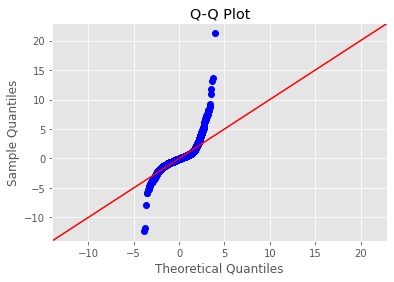

In [65]:
# check q-q plot for check of residual normality
sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
plt.title('Q-Q Plot')

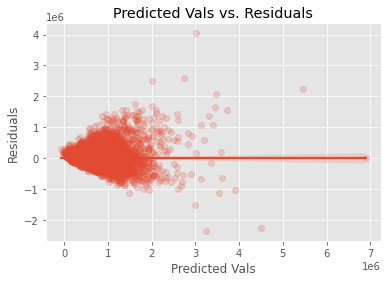

In [66]:
# check heteroscedascity
preds = model.predict(predictors)
sns.regplot(x=preds, y=model.resid, scatter_kws={'alpha': 0.2})
plt.title('Predicted Vals vs. Residuals')
plt.xlabel('Predicted Vals')
plt.ylabel('Residuals')
plt.show()

Baseline model shows q-q plot implying residuals are not normally distributed.  Additionally, patter in residual plot implies there is some homoscedasscity present. 

# Improving on Baseline 

Now that a baseline has been created to compare to, we can try to improve results through additional preprocessing and transformations of our dataset. We are most concerned with meeting requirements for linear regression and meeting all assumptions, which are currently being violated. 

In [69]:
# start with log transformation of price
preprocessed['log_price'] = np.log(preprocessed['price'])

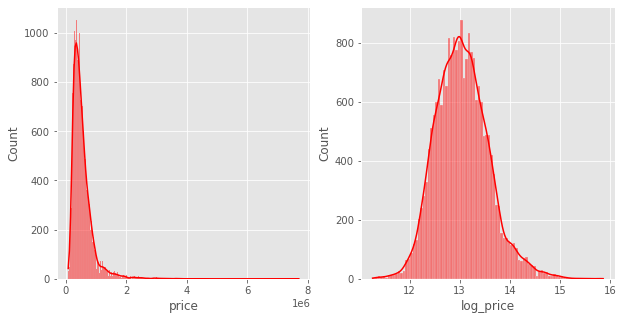

In [83]:
# compare histograms of price and log transformed price
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
sns.histplot(preprocessed['price'], ax=axes[0], kde=True, color='red')
sns.histplot(preprocessed['log_price'], ax=axes[1], kde=True, color='red')
plt.show()

From a visual inspection, log_price is looking far more normal.  Will plot features against log_price to see if relationships are stronger prior to modeling again.

In [86]:
preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21143 entries, 0 to 21596
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21143 non-null  float64
 1   bedrooms       21143 non-null  int64  
 2   sqft_lot       21143 non-null  int64  
 3   waterfront     21143 non-null  float64
 4   view           21143 non-null  float64
 5   condition      21143 non-null  int64  
 6   grade          21143 non-null  int64  
 7   sqft_above     21143 non-null  int64  
 8   sqft_basement  21143 non-null  float64
 9   yr_renovated   21143 non-null  float64
 10  lat            21143 non-null  float64
 11  long           21143 non-null  float64
 12  sqft_living15  21143 non-null  int64  
 13  sqft_lot15     21143 non-null  int64  
 14  month          21143 non-null  int64  
 15  floors_10      21143 non-null  float64
 16  bathrooms_100  21143 non-null  float64
 17  log_price      21143 non-null  float64
dtypes: flo

In [87]:
# set up categorical features
cat_feats = preprocessed[['bedrooms', 'waterfront', 'view', 'condition', 'grade',
                          'month', 'floors_10', 'bathrooms_100']]

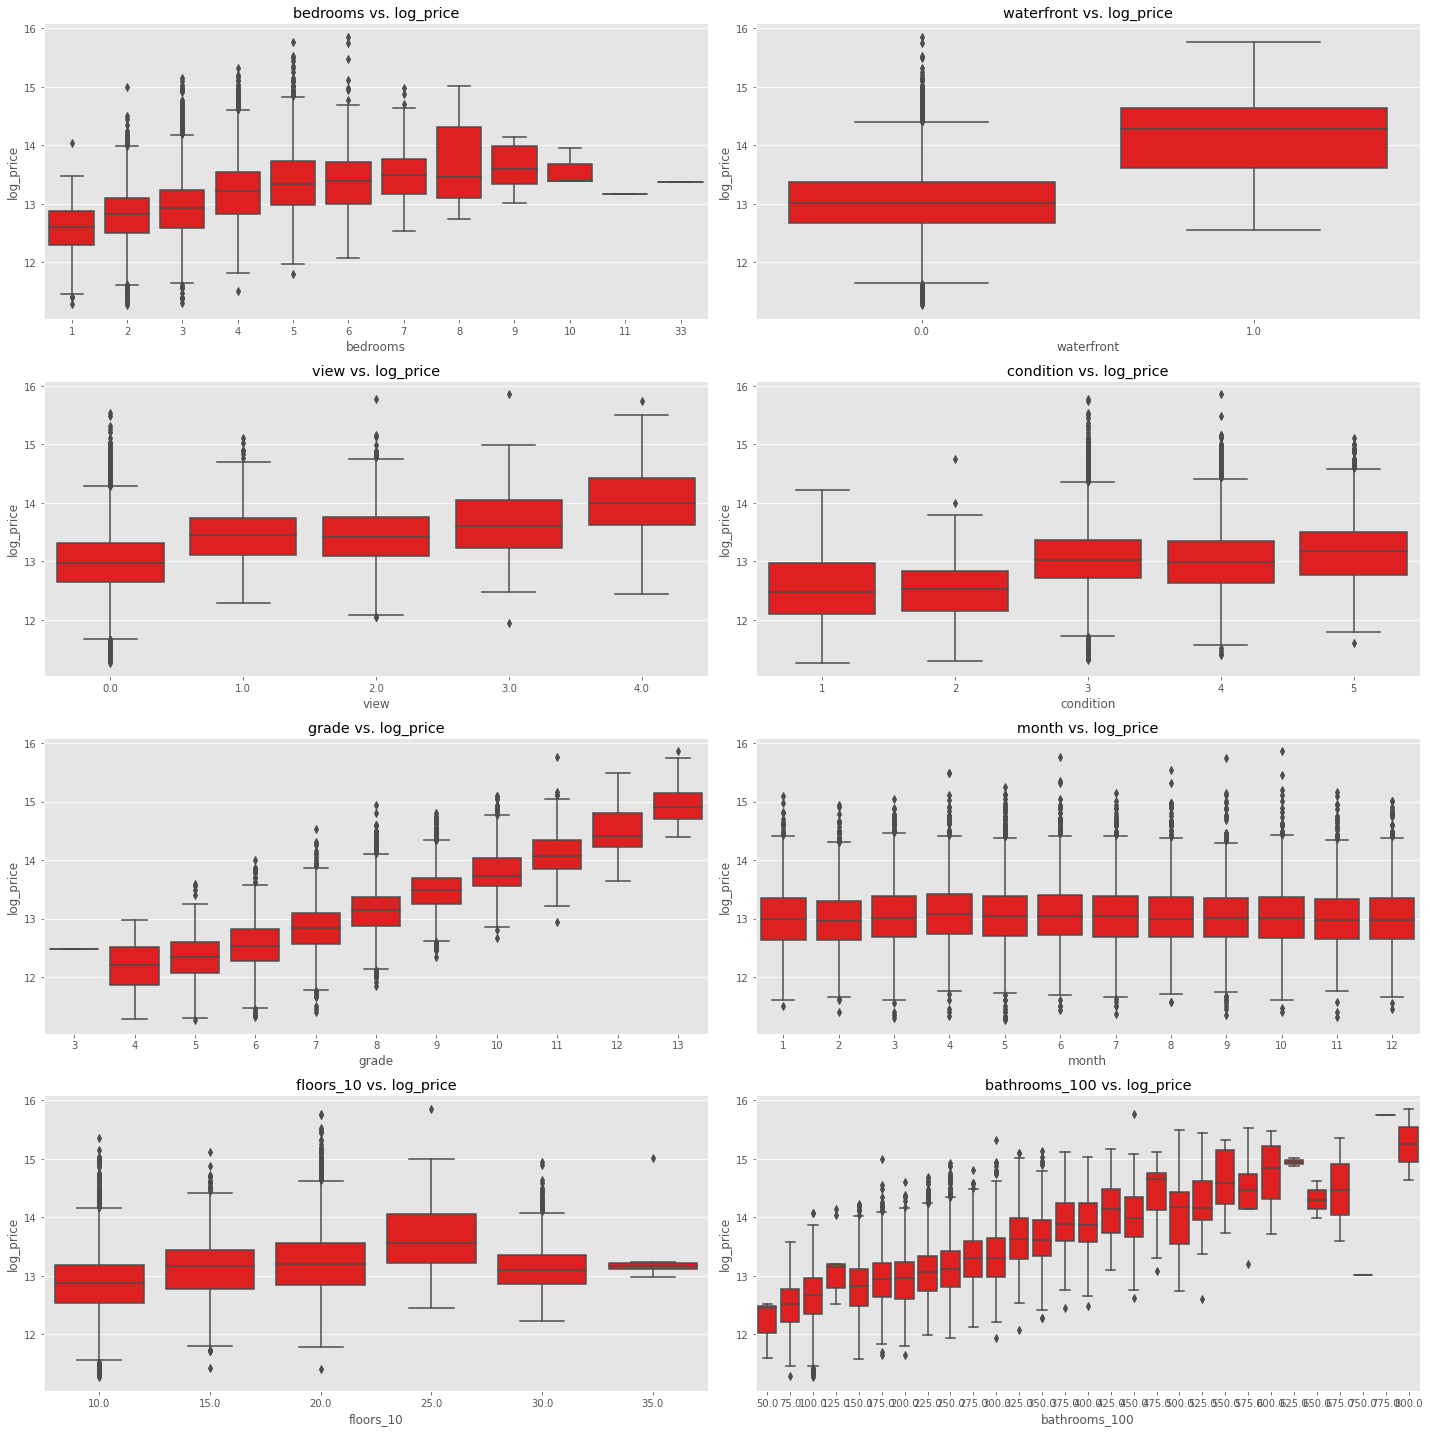

In [88]:
# plot boxplots of categorical features vs. log_price
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))
for ax, feat in zip(axes.flatten(), cat_feats):
    sns.boxplot(x=feat, y='log_price', data=preprocessed, ax=ax, color='red')
    ax.set_title(f'{feat} vs. log_price')
plt.tight_layout()

In [94]:
# separate out continuous features
cont_feats = preprocessed.drop(cat_feats, axis=1)
cont_feats = cont_feats.drop(['price', 'log_price'], axis=1)

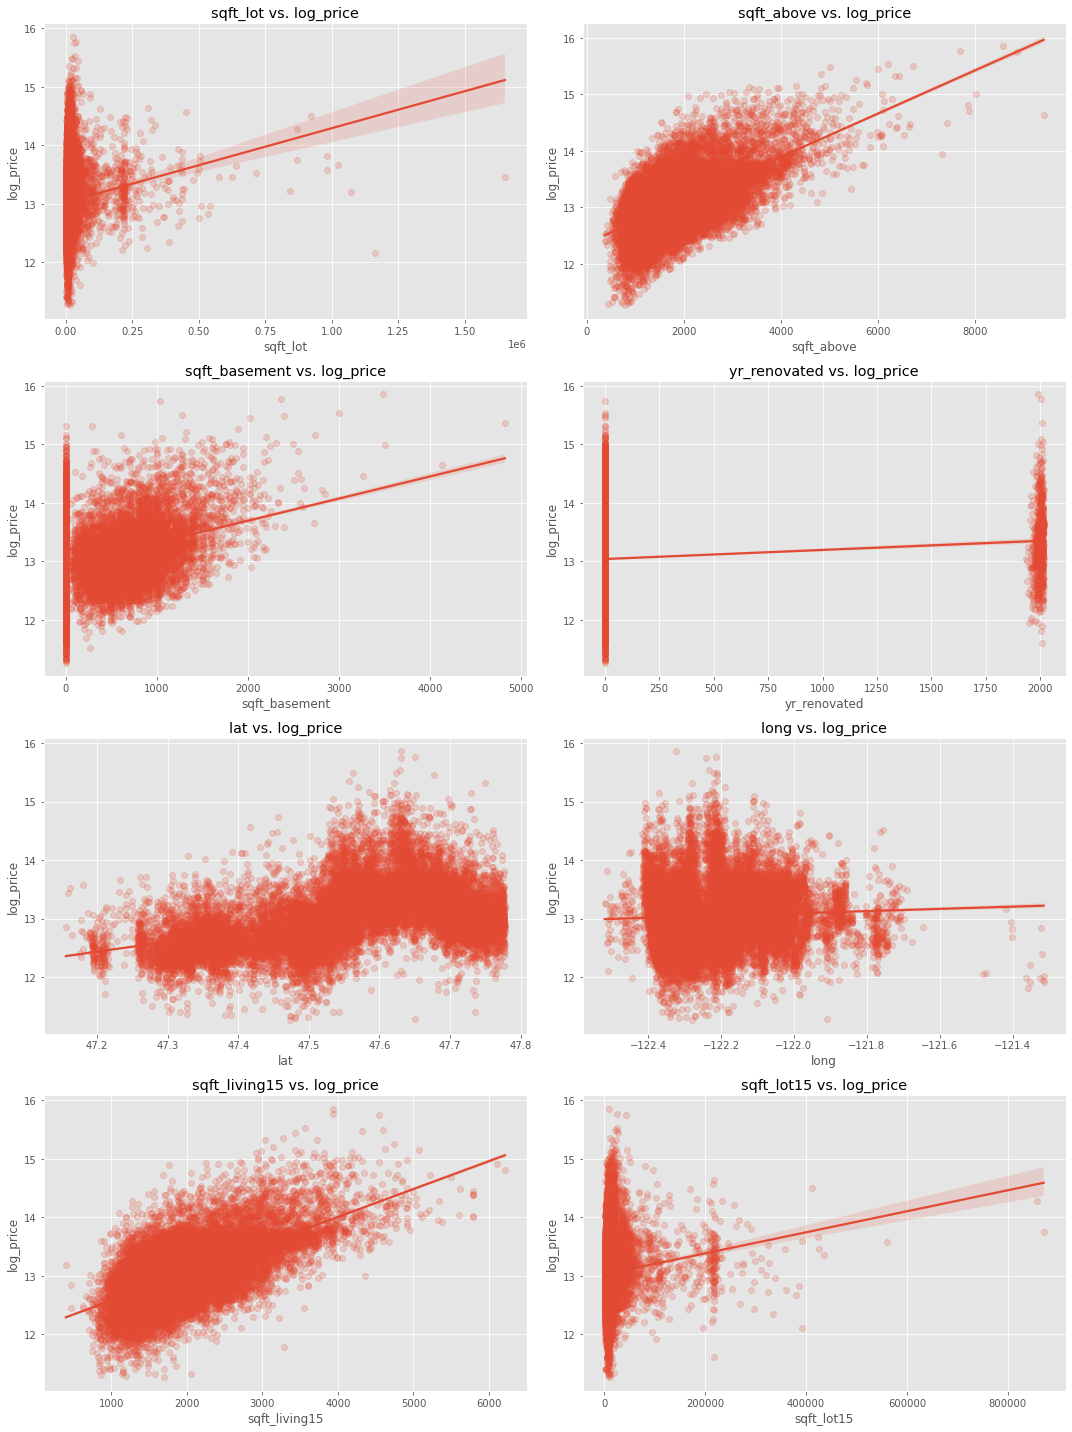

In [96]:
# plot scatterplots of cont. features vs. price
plot_viz(data=preprocessed, target='log_price', predictors=cont_feats, 
         nrows=4, ncols=2, figsize=(15, 20))

Relationships are looking stronger between features and log transformed price than with non-transformed price. Will continue using price going forward.  Move forward with removing non-linear relationships from cont features, one hot encode and run a second model.

In [98]:
# drop assumptions violating linearity assumption / not offering much predictive power
final_df = preprocessed.drop(['long', 'yr_renovated', 'month', 'price'], axis=1)

In [100]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21143 entries, 0 to 21596
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       21143 non-null  int64  
 1   sqft_lot       21143 non-null  int64  
 2   waterfront     21143 non-null  float64
 3   view           21143 non-null  float64
 4   condition      21143 non-null  int64  
 5   grade          21143 non-null  int64  
 6   sqft_above     21143 non-null  int64  
 7   sqft_basement  21143 non-null  float64
 8   lat            21143 non-null  float64
 9   sqft_living15  21143 non-null  int64  
 10  sqft_lot15     21143 non-null  int64  
 11  floors_10      21143 non-null  float64
 12  bathrooms_100  21143 non-null  float64
 13  log_price      21143 non-null  float64
dtypes: float64(7), int64(7)
memory usage: 3.0 MB


In [101]:
# one hot encode dummy variables
bedrooms_dummies = pd.get_dummies(preprocessed['bedrooms'], prefix='bedrooms', drop_first=True)
waterfront_dummies = pd.get_dummies(preprocessed['waterfront'], prefix='waterfront', drop_first=True)
view_dummies = pd.get_dummies(preprocessed['view'], prefix='view', drop_first=True)
condition_dummies = pd.get_dummies(preprocessed['condition'], prefix='condition', drop_first=True)
grade_dummies = pd.get_dummies(preprocessed['grade'], prefix='grade', drop_first=True)
floors_dummies = pd.get_dummies(preprocessed['floors_10'], prefix='floors_10', drop_first=True)
bathrooms_dummies = pd.get_dummies(preprocessed['bathrooms_100'], prefix='bathrooms_100', drop_first=True)

In [102]:
# concat with final_df
final_df = pd.concat([final_df, 
                      bedrooms_dummies,
                      waterfront_dummies,
                      view_dummies,
                      condition_dummies,
                      grade_dummies,
                      floors_dummies,
                      bathrooms_dummies], axis=1)

# drop initial cat columns
final_df = final_df.drop(['bedrooms', 'waterfront', 'view',
                          'condition', 'grade', 'floors_10', 'bathrooms_100'], axis=1)

In [104]:
# rerun stepwise selection
y = final_df['log_price']
X = final_df.drop('log_price', axis=1)
result = stepwise_selection(X, y, verbose=True)

Add  grade_11                       with p-value 0.0
Add  grade_7                        with p-value 0.0
Add  sqft_above                     with p-value 0.0
Add  sqft_living15                  with p-value 0.0
Add  lat                            with p-value 0.0
Add  sqft_basement                  with p-value 0.0
Add  grade_6                        with p-value 1.2416e-185
Add  waterfront_1.0                 with p-value 1.78857e-164
Add  condition_3                    with p-value 1.55708e-115
Add  grade_5                        with p-value 6.64212e-111
Add  grade_8                        with p-value 2.96103e-170
Add  floors_10_15.0                 with p-value 5.63707e-87
Add  view_3.0                       with p-value 6.76857e-47
Add  view_2.0                       with p-value 1.86572e-54
Add  view_4.0                       with p-value 1.00255e-56
Add  grade_4                        with p-value 6.91142e-45
Add  grade_9                        with p-value 7.84629e-45
Add  vi

In [105]:
# run regression with selected features
X = final_df[result]
y = final_df['log_price']
predictors = sm.add_constant(X)
model = sm.OLS(y, predictors).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     1908.
Date:                Fri, 11 Mar 2022   Prob (F-statistic):               0.00
Time:                        12:24:43   Log-Likelihood:                -1593.8
No. Observations:               21143   AIC:                             3258.
Df Residuals:                   21108   BIC:                             3536.
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -55.8731      0.647    -86.324      0.000     -57.142     -54.604
grade_11               -0.1348      0.030     -4.563      0.000      -0.193      -0.077
grade_7                -0.6476      0.030    -21.738      0.000      -0.706      -0.589
sqft_above              0.0002   4.58e-06     35.614      0.000       0.000       0.000
sqft_living15        8.843e-05    4.5e-06     19.671      0.000    7.96e-05    9.72e-05
lat                     1.4460      0.014    106.552      0.000       1.419       1.473
sqft_basement           0.0002    5.1e-06     37.896      0.000       0.000       0.000
grade_6                -0.8048      0.031    -26.087      0.000      -0.865      -0.744
waterfront_1.0          0.4134      0.027     15.458      0.000       0.361       0.466
condition_3             0.0970      0.019      5.057      0.000       0.059       0.135
grade_5                -0.9459      0.035    -26.981      0.000      -1.015      -0.877
grade_8                -0.4897      0.029    -16.818      0.000      -0.547      -0.433
floors_10_15.0          0.1427      0.007     21.037      0.000       0.129       0.156
view_3.0                0.2098      0.012     17.018      0.000       0.186       0.234
view_2.0                0.1502      0.009     16.685      0.000       0.133       0.168
view_4.0                0.2857      0.019     15.388      0.000       0.249       0.322
grade_4                -1.0389      0.059    -17.553      0.000      -1.155      -0.923
grade_9                -0.3258      0.028    -11.467      0.000      -0.381      -0.270
view_1.0                0.1981      0.015     13.449      0.000       0.169       0.227
condition_5             0.2737      0.020     13.637      0.000       0.234       0.313
condition_4             0.1854      0.019      9.605      0.000       0.148       0.223
floors_10_25.0          0.1970      0.022      9.110      0.000       0.155       0.239
bedrooms_2              0.0460      0.006      7.451      0.000       0.034       0.058
grade_10               -0.2086      0.028     -7.383      0.000      -0.264      -0.153
floors_10_20.0          0.0415      0.006      7.294      0.000       0.030       0.053
bathrooms_100_250.0    -0.0402      0.005     -7.895      0.000      -0.050      -0.030
sqft_lot             4.773e-07   6.33e-08      7.539      0.000    3.53e-07    6.01e-07
bathrooms_100_100.0    -0.0381      0.006     -5.875      0.000      -0.051      -0.025
sqft_lot15          -4.696e-07   9.64e-08     -4.872      0.000   -6.59e-07   -2.81e-07
bathrooms_100_800.0    -0.9073      0.189     -4.801      0.000      -1.278      -0.537
bathrooms_100_375.0     0.0951      0.022      4.380      0.000       0.053       0.138
bathrooms_100_150.0    -0.0380      0.008     -4.889      0.000      -0.053      -0.023
flo

Text(0.5, 1.0, 'Q-Q Plot')

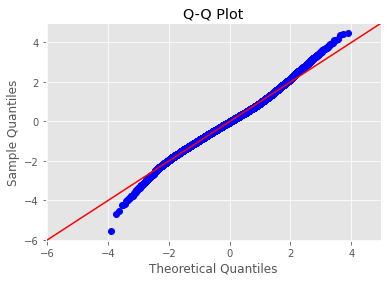

In [106]:
# check q-q plot for check of residual normality
sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
plt.title('Q-Q Plot')

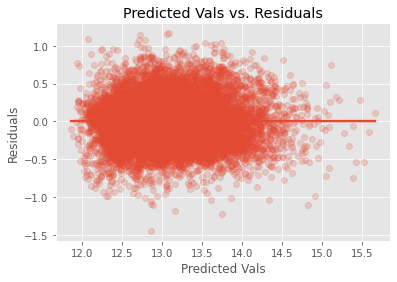

In [107]:
# check heteroscedascity
preds = model.predict(predictors)
sns.regplot(x=preds, y=model.resid, scatter_kws={'alpha': 0.2})
plt.title('Predicted Vals vs. Residuals')
plt.xlabel('Predicted Vals')
plt.ylabel('Residuals')
plt.show()

Evaluating our Q-Q plot and residual plot, we can see we are much more inline with assumptions of linear regression than previously prior to log transforming price.  Results are looking fairly strong with an R-squared value of 75.5%

# Final Model Iteration
Treat ordinal categorical variables as non-categorical and be more strict with feature selection.